## **Read and Filter Data**

In [2]:
import pandas as pd
import numpy as np

# Read Data as a pandas dataframe object
travis_df = pd.read_csv('./TravisTorrent-3-Projects-With-Tests.csv') # Rows: 4549
# Data set retrieved from TravisTorrent via: SELECT * FROM [travistorrent-bq:data.2017_01_11] WHERE gh_project_name IN ('facebook/presto', 'reactjs/react-rails', 'Shopify/shopify_api') AND tr_log_bool_tests_ran = true

travis_df.head()

,tr_build_id,gh_project_name,gh_is_pr,gh_pr_created_at,gh_pull_req_num,gh_lang,git_merged_with,git_branch,gh_num_commits_in_push,gh_commits_in_push,...,tr_log_frameworks,tr_log_bool_tests_ran,tr_log_bool_tests_failed,tr_log_num_tests_ok,tr_log_num_tests_failed,tr_log_num_tests_run,tr_log_num_tests_skipped,tr_log_tests_failed,tr_log_testduration,tr_log_buildduration
0,14267990,facebook/presto,False,NaN,NaN,java,NaN,master,4.0,0c01729174cf61f0edadb90fb87a1df1355e7595#e364a...,...,junit,True,True,1233,1,1234.0,0,TestSqlStageExecution#,578.22,NaN
1,14329633,facebook/presto,False,NaN,NaN,java,NaN,master,1.0,59b2de9e2cecff5c724b5e69b58bcf6f0d52080a,...,junit,True,True,252,1,253.0,242,TestDistributedQueries>AbstractTestQueries#,690.86,NaN
2,14345694,facebook/presto,True,2013-11-21T21:39:14,869.0,java,merge_button,master,1.0,94cbb72e84749d70c54a6423c5fcfa965c1156ee,...,junit,True,True,5,1,6.0,0,Test#The exception was thrown with the wrong m...,679.09,NaN
3,14346675,facebook/presto,False,NaN,NaN,java,NaN,master,1.0,94cbb72e84749d70c54a6423c5fcfa965c1156ee,...,junit,True,True,5,1,6.0,0,Test#The exception was thrown with the wrong m...,730.64,NaN
4,14399800,facebook/presto,False,NaN,NaN,java,NaN,master,1.0,92c81ae5f2ce121b4420d51cc9d821982f4ff916,...,junit,True,True,252,1,253.0,242,Failure unable to create new native thread#,646.46,NaN


## **RQ1 Analysis**
Do failing unit tests cause the most failures in continuous integration pipelines?

# of Total Unique Pipeline Build Failures: 645
# of Unique Pipeline Build Failures from Tests: 407
# of Unique Pipeline Build Failures from Causes Other Than Tests: 238


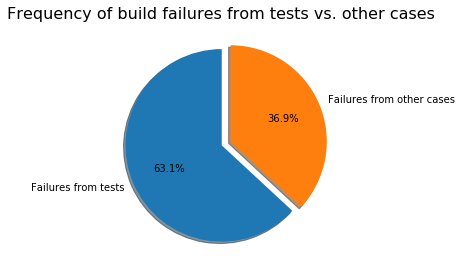

Example of Error Different than Test Failure in Build 31052348 -> ReferenceError: Can't find variable: Turbolinks


In [7]:
import matplotlib.pyplot as plt

# Data where some failure occured
failed_cases = travis_df.loc[travis_df['tr_status'] == 'failed'] # get data where failures occured (926 rows)
num_unique_build_failures = len(failed_cases['tr_build_id'].unique()) # find failures with unique build ids (645 rows)
print("# of Total Unique Pipeline Build Failures: {}".format(num_unique_build_failures))

# Data where the failure was caused by tests
caused_by_tests = failed_cases.loc[failed_cases['tr_log_bool_tests_failed'] == True] # get data where failures occured by tests (472 rows)
num_unique_build_failures_from_tests = len(caused_by_tests['tr_build_id'].unique()) # find failures from tests with unique build ids (407 rows)
print("# of Unique Pipeline Build Failures from Tests: {}".format(num_unique_build_failures_from_tests))

# Total failures minus failures by tests
print("# of Unique Pipeline Build Failures from Causes Other Than Tests: {}".format(num_unique_build_failures - num_unique_build_failures_from_tests))

# Plot the results of the failures
labels = 'Failures from tests', 'Failures from other cases'
sizes = [num_unique_build_failures_from_tests, num_unique_build_failures - num_unique_build_failures_from_tests]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
fig1.suptitle('Frequency of build failures from tests vs. other cases', fontsize=16)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

# Find an issue caused by something other than tests (proof of concept)
not_caused_by_tests = failed_cases.loc[failed_cases['tr_log_bool_tests_failed'] == False]
issue_where_tests_passed = not_caused_by_tests.loc[not_caused_by_tests['tr_build_id'] == 31052348].iloc[0]
# Manually look up the Travis CI build here: https://travis-ci.org/github/reactjs/react-rails/builds/31052348
print("Example of Error Different than Test Failure in Build {} -> {}".format(issue_where_tests_passed['tr_build_id'], "ReferenceError: Can't find variable: Turbolinks"))

## **RQ2 Analysis**
Does the majority (i.e., greater than 50%) of continuous pipeline failures result from issues that take less than 1 hour to resolve?

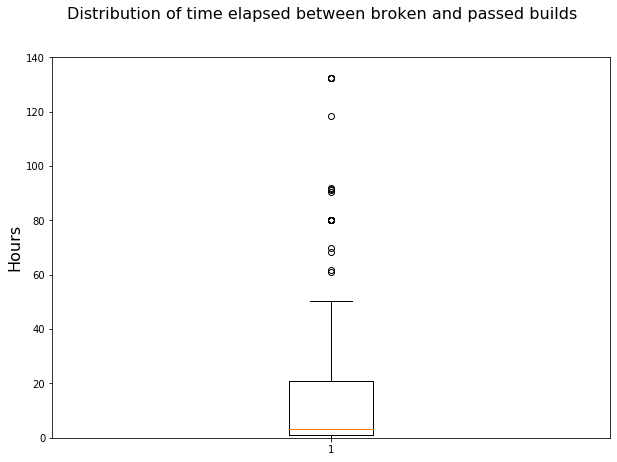

Statistics (in hours):
Lower Wisker: -0.39222222222222225
Lower Quartile: 1.0608333333333335
Median: 3.322638888888889
Upper Quartile: 20.86722222222222
Upper Wisker: 50.33777777777778



—————————————————————————————————————————————————————————————————————————————





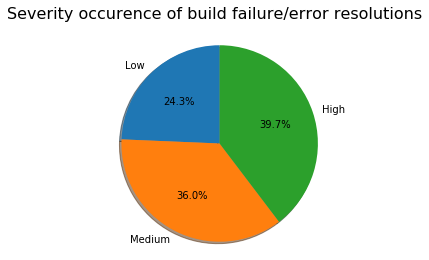

Severity Occurence Results:
Low: 73 | Medium: 108 | High: 119


In [8]:
import datetime
# Find the builds that passed
passed_cases = travis_df.loc[travis_df['tr_status'] == 'passed'] # get data where pipelines successful (3264 rows)
extracted_ids = passed_cases[["tr_prev_build", "tr_build_id"]] # [prev, current]

# Helper Function: Check if the previous build failed or errored
def prev_build_status_failed_or_errored(build):
    passed_rows = build.loc[build['tr_status'].isin(['failed', 'errored'])]
    if build.shape[0] == passed_rows.shape[0]:
      return True
    else:
      return False

# Helper Function: Calculate the time between current success and past failed build
def calc_time_between(prev_build_start, prev_build_dur, curr_build_start, curr_build_dur): # gh_build_started_at, tr_duration
  elapsed_time = pd.to_datetime(curr_build_start) - pd.to_datetime(prev_build_start)
  elapsed_time_seconds = elapsed_time.total_seconds()
  total = elapsed_time_seconds - prev_build_dur + curr_build_dur
  return total

list_of_elapsed = []

# Loop through each build, and find elapsed time between past failure/error and current successful build
for index, row in extracted_ids.iterrows():
  prev_build = travis_df.loc[travis_df['tr_build_id'] == row['tr_prev_build']]
  if not prev_build.empty:
    curr_build = passed_cases.iloc[index - 926]
    prev_failure_or_error = prev_build_status_failed_or_errored(prev_build)
    if prev_failure_or_error == True:
      prev_build = prev_build.iloc[0]
      time_elapsed = calc_time_between(prev_build['gh_build_started_at'], prev_build['tr_duration'], curr_build['gh_build_started_at'], curr_build['tr_duration'])
      list_of_elapsed.append(time_elapsed/3600.0)

# Plot the data in a box plot and return values
fig = plt.figure(figsize =(10, 7)) 
bp = plt.boxplot(list_of_elapsed)
fig.suptitle('Distribution of time elapsed between broken and passed builds', fontsize=16)
plt.ylabel('Hours', fontsize=16)
axes = plt.gca()
axes.set_ylim([0, 140])
plt.show()

# Statistics:
print('\033[1m'+'Statistics (in hours):'+'\033[0m')
print('Lower Wisker: {}'.format(bp['whiskers'][0].get_ydata()[1]))
print('Lower Quartile: {}'.format(bp['boxes'][0].get_ydata()[1]))
print('Median: {}'.format(bp['medians'][0].get_ydata()[1]))
print('Upper Quartile: {}'.format(bp['boxes'][0].get_ydata()[2]))
print('Upper Wisker: {}'.format(bp['whiskers'][(0)+1].get_ydata()[1]))

print('\n\n\n\033[1m'+'—————————————————————————————————————————————————————————————————————————————'+'\033[0m\n\n\n')

# Calculate the occurence of each severity
def get_count_hours(list):
  low = 0
  medium = 0
  high = 0
  for time in list:
    if time < 1:
      low += 1
    elif time < 8:
      medium += 1
    else:
      high +=1
  return low, medium, high

low, medium, high = get_count_hours(list_of_elapsed)

# Pie chart
labels = 'Low', 'Medium', 'High'
sizes = [low, medium, high]
explode = (0, 0, 0)
fig1, ax1 = plt.subplots()
fig1.suptitle('Severity occurence of build failure/error resolutions', fontsize=16)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

print('\033[1m'+'Severity Occurence Results:'+'\033[0m')
print('Low: {} | Medium: {} | High: {}'.format(low, medium, high))


    

## **RQ3 Analysis**
Does the size of a commit or the number of jobs in a pipeline correlate with pipeline failures more frequently?

In [ ]:
# Future Work